<a href="https://colab.research.google.com/github/Alex16092000/ConvNext_adapted/blob/main/ATM_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Load necessary libraries
library(tidyverse)
library(ggplot2)
install.packages("xts")
library(xts)
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
# Load the data
data <- readRDS("ATM_data_Schendelmann_Alexander.rds")

# preprocessing
data$ymd <- as.Date(data$ymd)
data$holiday <- as.logical(data$holiday)
data <- data %>%
  rename(festivity = holiday) %>%
  rename(date = ymd) %>%
  arrange(unit, date) %>%
  group_by(unit) %>%
  mutate(
    pre_festivity = lead(festivity, default = FALSE),
    month = month(date, label = TRUE, abbr = FALSE),
    weekday = wday(date, label = TRUE, abbr = FALSE)
  )
data <- data[, c("date", "unit", "year", "month", "weekday", "festivity", "pre_festivity", "withdrawn")] # reorder columns
head(data)

date,unit,year,month,weekday,festivity,pre_festivity,withdrawn
<date>,<int>,<dbl>,<ord>,<ord>,<lgl>,<lgl>,<dbl>
2007-01-01,52,2007,January,Monday,TRUE,FALSE,15690
2007-01-02,52,2007,January,Tuesday,FALSE,FALSE,106880
2007-01-03,52,2007,January,Wednesday,FALSE,FALSE,88030
2007-01-04,52,2007,January,Thursday,FALSE,FALSE,91310
2007-01-05,52,2007,January,Friday,FALSE,TRUE,109770
2007-01-06,52,2007,January,Saturday,TRUE,FALSE,23000


Warning message:
“Removed 1484 rows containing missing values or values outside the scale range
(`geom_point()`).”


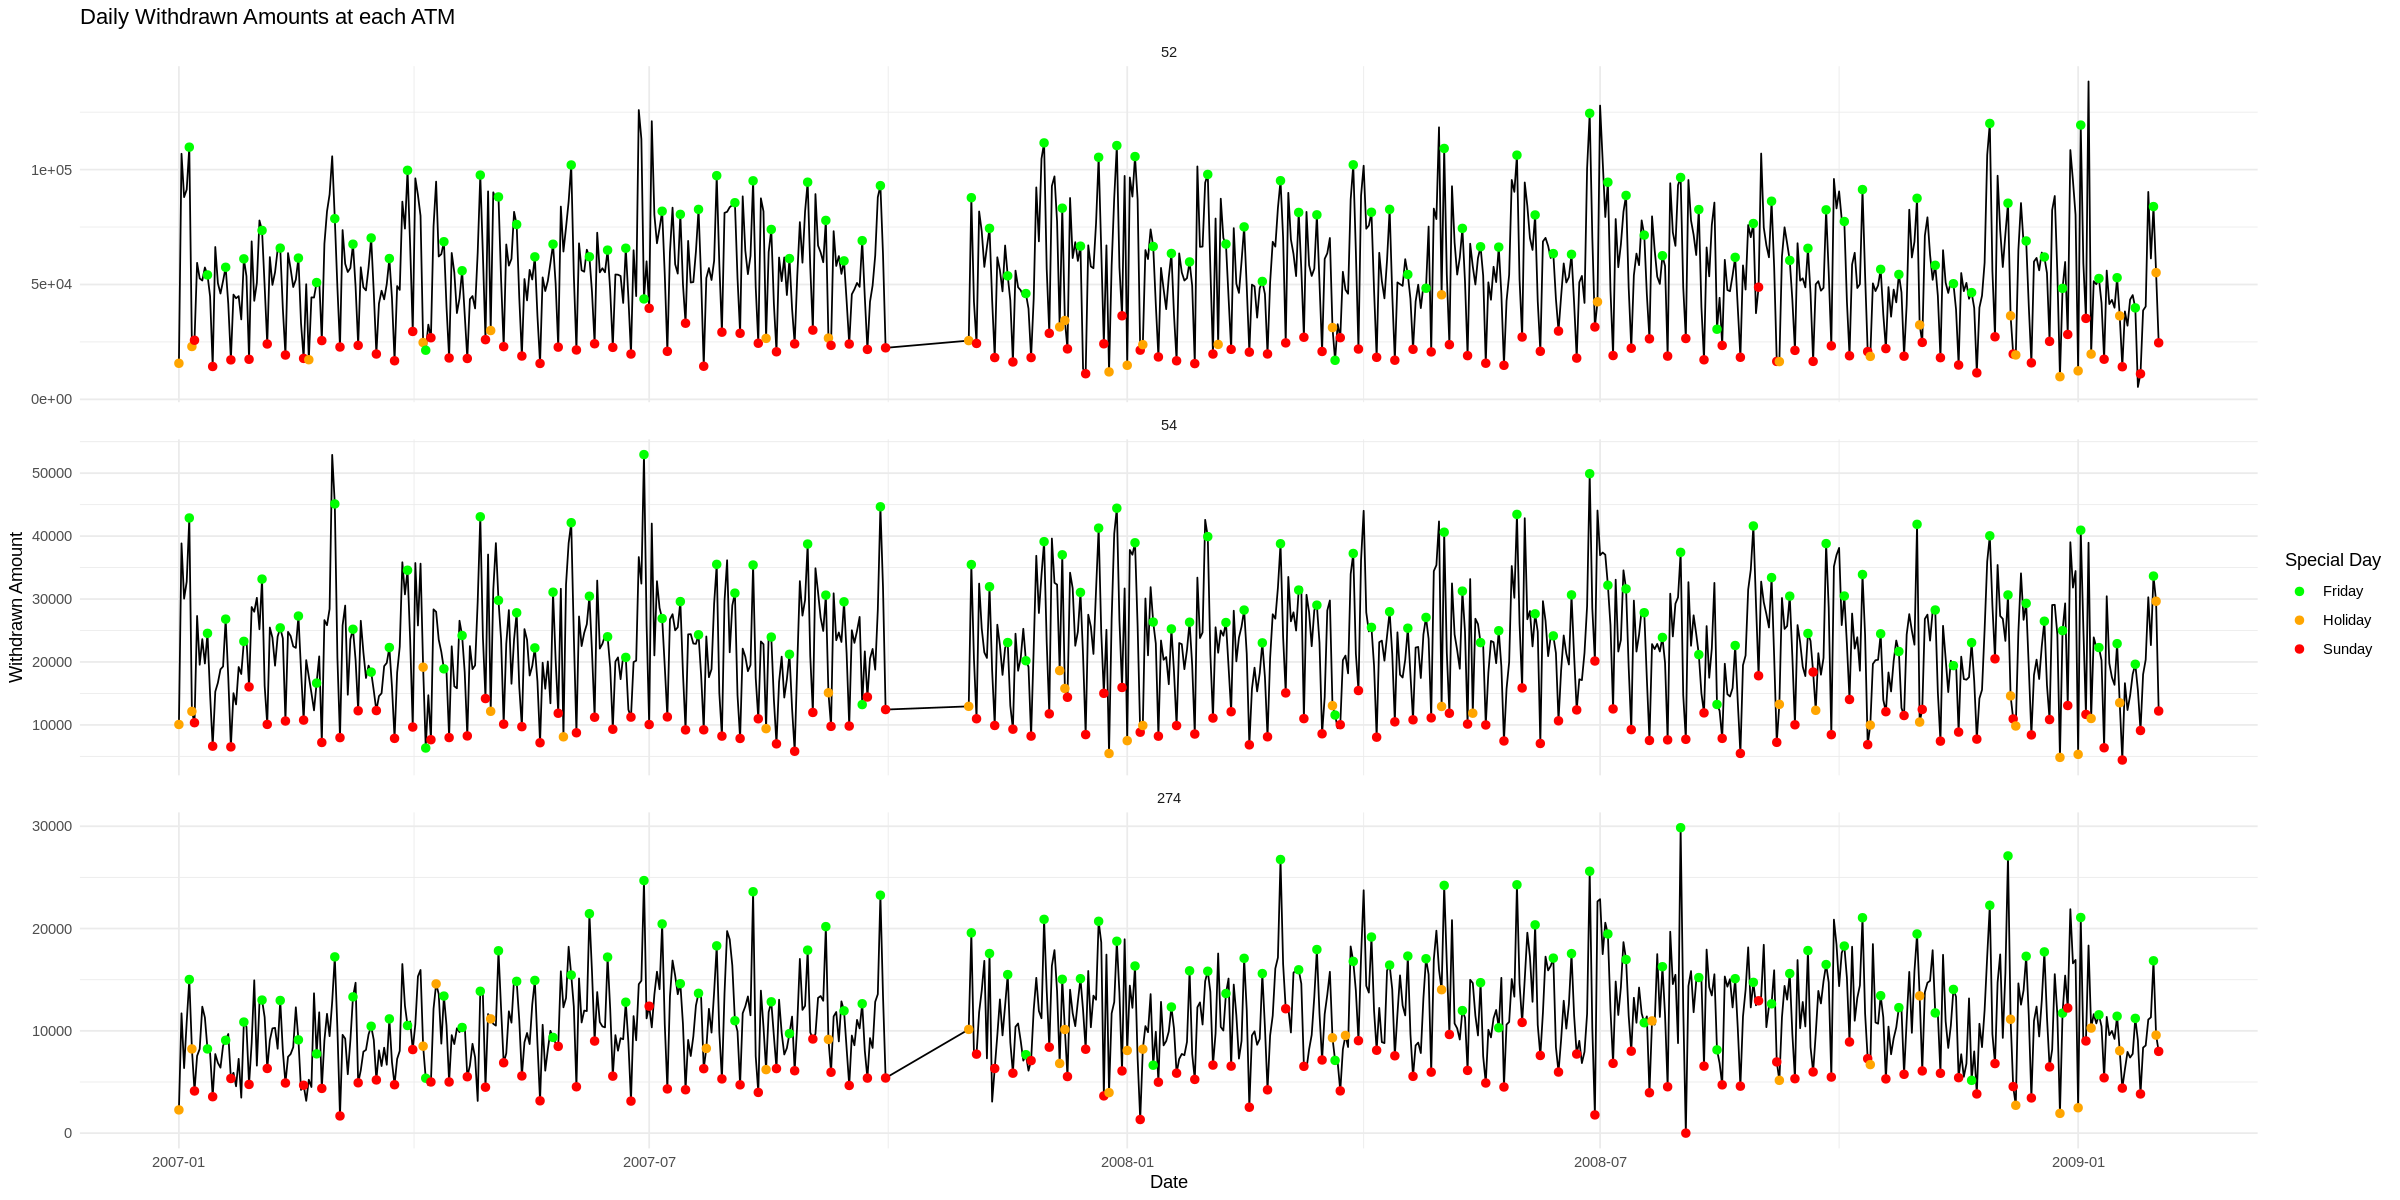

In [15]:
# Plot the time series data grouped by the unit (ATM)
library(repr)
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data, aes(x = date, y = withdrawn)) +
  geom_line() +
  geom_point(aes(color = case_when(
    wday(date) == 6 ~ "Friday",
    wday(date) == 1 ~ "Sunday",
    festivity == TRUE ~ "Holiday"
  )), size = 2) +
  # geom_point(aes(color = weekday), size = 1) +
  facet_wrap(~ unit, scales = "free_y", ncol=1) +
  labs(title = "Daily Withdrawn Amounts at each ATM",
       x = "Date",
       y = "Withdrawn Amount",
       color = "Special Day") +
  scale_color_manual(values = c(
    "Friday" = "green",
    "Sunday" = "red",
    "Holiday" = "orange"
  ), na.translate = FALSE) +
  theme_minimal()

In [17]:
# Random Forests
grouped_by_unit <- split(data, data$unit)
models <- list()
metrics <- list()
for (unit in names(grouped_by_unit)) {
  atm = grouped_by_unit[[unit]]
  ts <- xts(atm$withdrawn, order.by=atm$date)

  # include lag features (shifting one week)
  ts_lags <- lag.xts(ts, 1:7)
  lagged_data <- cbind(atm, ts_lags)
  lagged_data <- lagged_data[complete.cases(lagged_data),]

  # Split the dataset into train and test
  train_data <- lagged_data %>% filter(date < as.Date("2008-10-01"))
  test_data <- lagged_data %>% filter(date >= as.Date("2008-11-01") & date < as.Date("2008-12-01"))

  features_sets <- list(
    set1 = withdrawn ~ .,
    set2 = withdrawn ~ year + month + weekday + festivity + pre_festivity,
    set3 = withdrawn ~ lag1 + lag2 + lag3 + lag4 + lag5 + lag6 + lag7
  )
  for (feature_set in features_sets) {
    model <- train(feature_set, train_data, method = "rf")
    pred = predict(model, test_data)
    metrics[[unit]] <- list(metrics[[unit]], postResample(pred, test_data$withdrawn))
    models[[unit]] <- list(models[[unit]], model)
  }
}

ERROR: Error: Required packages are missing: randomForest


In [ ]:
# model evaluation
for (unit_models in models) {
  models_compare <- resamples(unit_models)
  summary(models_compare)
}

# TODO: provide forecast for march 2009 using the best model
for (unit in names(grouped_by_unit)) {
  best_model <- models[unit][...]

}